In [64]:
import re
import demoji
import emoji
import warnings
# from google.colab import drive
# drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [65]:
df_tweets = pd.read_csv("others_dataset.csv")

In [66]:
df_tweets

,id,name,username,created_at,verified,location,description,followers_count,following_count,tweet_count,account_type,url
0,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/FpAstfF67l
1,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/pw6xYLUph5
2,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/XYsPhTkcDX
3,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/yyadIxV48k
4,787405734442958848,The Best In Dumbest,best_in_dumbest,2016-10-15T21:32:11.000Z,False,NaN,"Blame @MoistHorse, Inspired by @MakingInvisibl...",1997,5,17090,bot,https://t.co/WJxZL1TkfM
...,...,...,...,...,...,...,...,...,...,...,...,...
88127,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/kfFSga83RW
88128,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/VS3mHXkZYU
88129,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/hhfB4q2GkD
88130,524121160,차학연 VIXX_N,CHA_NNNNN,2012-03-14T07:48:21.000Z,True,별빛이 있는 곳,NaN,803247,7,3159,human,https://t.co/h5kv3eJ5Il


In [67]:
def box_plot(colname, df, info):
    # Plot graph
    plt.figure(figsize=(2,6))
    ax = sns.boxplot(data=df, y=colname)
    ax.set_title(f'Distribution of {colname} ({info} removing outliers)')
    
#     plt.savefig(f'Charts\\{colname}_boxplot_{info}.png', dpi=300)
    plt.show()

def histogram(colname, df, info):
    # Plot graph
    plt.figure(figsize=(5,5))
    ax = sns.histplot(data=df, x=colname, bins=30)
    ax.set_title(f'Histogram of {colname} ({info} log transformation)')
    
#     plt.savefig(f'Charts\\{colname}_histogram_{info}.png', dpi=300)
    plt.show()

def bar_chart(colname, df, rotate):
    # Plot graph
    plt.figure(figsize=(15,7))
    ax = sns.countplot(x=colname, data=df, order=df[colname].value_counts().index)
    ax.set_title(f'Distribution of assets across {colname}')
    ax.set_xlabel(colname)
    ax.set_ylabel(f'Asset count across {colname}')

    # Label
    labels = df[colname].value_counts()
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+2, label, ha='center', va='bottom')

    if rotate:
        plt.xticks(rotation = 45)

#     plt.savefig(f'Charts\\{colname}.png', dpi=300)
    plt.show()

def cum_sum_chart(colname, df):
    fig, ax = plt.subplots(figsize = (16,8))
    plt.plot(np.cumsum(df[colname].value_counts()[:20]/df.shape[0]))
    plt.ylabel("Proportion of Total")
    plt.xticks(rotation = 45)
    plt.xlabel(colname)
    plt.grid()

#     plt.savefig(f'Charts\\{colname}_cumsum.png', dpi=300)
    plt.show()

def heat_map(name, df):
    associations(df, nom_nom_assoc="theil", figsize=(14,12))
#     plt.savefig(f"Charts\\{name}.png", dpi=300)
    plt.show()

In [68]:
def url_text(df):
    pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    df['url'] = df["uncleaned_text"].str.extract(pattern, expand=True)
    return df

def username(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["un_no_of_char"] = df["username"].apply(lambda x: len(str(x)))
    df["un_special_char"] = df["username"].apply(lambda x: special_char.search(str(x)) != None)
    df["un_uppercase"] = df["username"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def name(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["name_no_of_char"] = df["name"].apply(lambda x: len(str(x)))
    df["name_special_char"] = df["name"].apply(lambda x: special_char.search(str(x)) != None)
    df["name_uppercase"] = df["name"].apply(lambda x: bool(re.match(r'\w*[A-Z]\w*', str(x))))
    return df

def description(df):
    #user_tags = re.compile('[@]')
    #hastags = re.compile('[#]')
    user_tags = r'\B@\w*[a-zA-Z]*\w*'
    hashtags = r'\B#\w*[a-zA-Z]+\w*'
    links = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
    df["des_no_of_usertags"] = df["description"].apply(lambda x: len(re.findall(user_tags, str(x)))) #str(x).count('@'))
    df["des_no_of_hashtags"] = df["description"].apply(lambda x: len(re.findall(hashtags, str(x)))) #str(x).count('#'))
    df["des_external_links"] = df["description"].apply(lambda x: re.findall(links, str(x)) != [])
    return df

def location(df):
    df["location"] = ~df_tweets["location"].isna() # false = location is NaN; true = has location
    return df
  
def time(df):
    df["created_time"] = df["created_at"].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').time())
    return df

In [69]:
df_tweets = time(df_tweets)
df_tweets = username(df_tweets)
df_tweets = name(df_tweets)
df_tweets = description(df_tweets)
df_tweets = location(df_tweets)

In [70]:
df_tweets = df_tweets.drop_duplicates(subset=['id'], keep='first')

In [71]:
new_df_tweets = df_tweets.drop(columns=["id", "name", "username", "description", "url"])

In [72]:
new_df_tweets

,created_at,verified,location,followers_count,following_count,tweet_count,account_type,created_time,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links
0,2016-10-15T21:32:11.000Z,False,False,1997,5,17090,bot,21:32:11,15,True,False,19,False,True,2,0,False
5,2016-11-09T05:01:30.000Z,False,True,785,829,251,human,05:01:30,12,False,True,8,False,True,0,0,False
9,2017-06-17T05:34:27.000Z,False,False,243,1232,1469,human,05:34:27,8,False,True,11,False,False,0,0,False
13,2012-01-15T16:32:35.000Z,True,True,737048,128,4739,human,16:32:35,13,False,True,14,False,True,1,0,False
16,2009-07-08T22:22:59.000Z,True,True,281703,1599,14785,human,22:22:59,14,False,False,16,False,True,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88114,2009-08-13T14:03:05.000Z,True,False,2025977,947,194749,human,14:03:05,11,True,False,13,False,True,1,0,False
88116,2009-11-21T14:39:59.000Z,True,True,367523,17291,24084,human,14:39:59,14,False,True,10,False,True,2,0,False
88120,2012-05-21T23:04:09.000Z,False,False,395,492,21437,bot,23:04:09,14,False,True,16,False,True,0,0,False
88125,2015-06-28T16:19:18.000Z,False,False,159,618,3021,human,16:19:18,8,False,True,14,False,True,0,0,False


In [73]:
new_df_tweets.to_csv("cleaned_others_dataset.csv", index = False)

Text(0.5, 1.0, 'human')

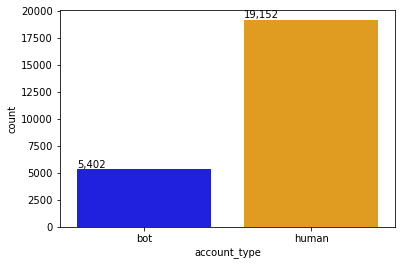

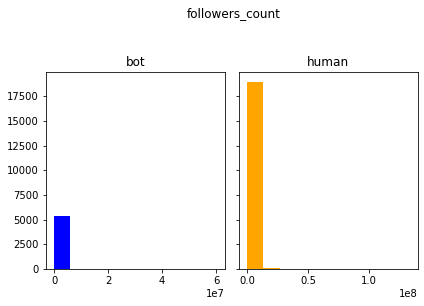

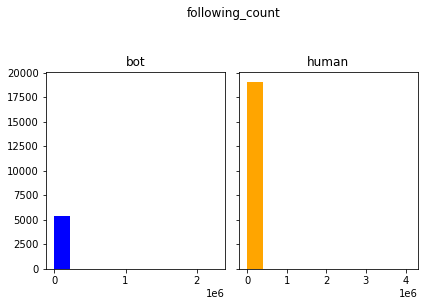

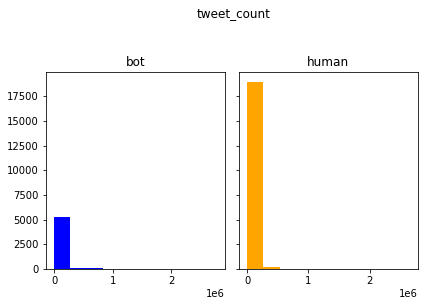

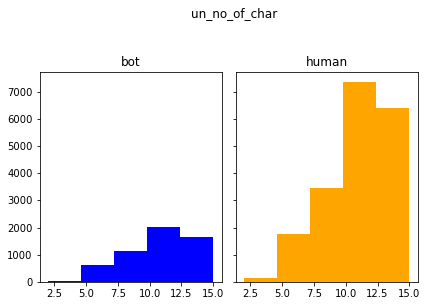

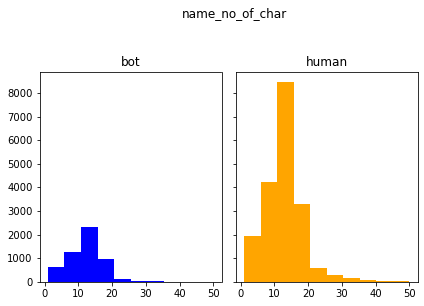

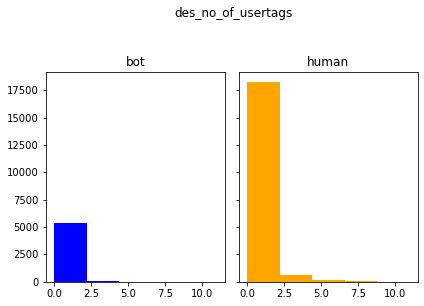

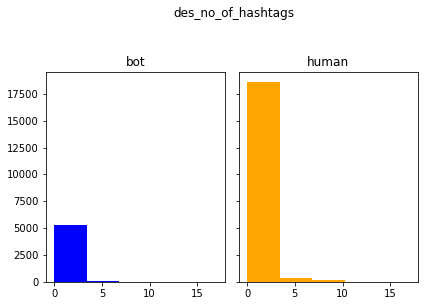

In [74]:
# count of bot accounts vs human accounts
plot1 = sns.countplot(df_tweets["account_type"], palette=['b', 'orange'])
for p in plot1.patches:
    plot1.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

bot_data = new_df_tweets.loc[(df_tweets.account_type == "bot")]
human_data = new_df_tweets.loc[(df_tweets.account_type == "human")]

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle("followers_count", y=1.05, x=0.55)
axs[0].hist(bot_data["followers_count"], color='b')
axs[0].set_title('bot')
axs[1].hist(human_data["followers_count"], color='orange')
axs[1].set_title('human')

fig, axs2 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle("following_count", y=1.05, x=0.55)
axs2[0].hist(bot_data["following_count"], color='b')
axs2[0].set_title('bot')
axs2[1].hist(human_data["following_count"], color='orange')
axs2[1].set_title('human')

fig, axs3 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('tweet_count', y=1.05, x=0.55)
axs3[0].hist(bot_data["tweet_count"], color='b')
axs3[0].set_title('bot')
axs3[1].hist(human_data["tweet_count"], color='orange')
axs3[1].set_title('human')

# max number of characters in username is 15
fig, axs4 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('un_no_of_char', y=1.05, x=0.55)
axs4[0].hist(bot_data["un_no_of_char"], color='b', bins=5)
axs4[0].set_title('bot')
axs4[1].hist(human_data["un_no_of_char"], color='orange', bins=5)
axs4[1].set_title('human')

fig, axs5 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('name_no_of_char', y=1.05, x=0.55)
axs5[0].hist(bot_data["name_no_of_char"], color='b')
axs5[0].set_title('bot')
axs5[1].hist(human_data["name_no_of_char"], color='orange')
axs5[1].set_title('human')

fig, axs6 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('des_no_of_usertags', y=1.05, x=0.55)
axs6[0].hist(bot_data["des_no_of_usertags"], color='b', bins=5)
axs6[0].set_title('bot')
axs6[1].hist(human_data["des_no_of_usertags"], color='orange', bins=5)
axs6[1].set_title('human')

fig, axs7 = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle('des_no_of_hashtags', y=1.05, x=0.55)
axs7[0].hist(bot_data["des_no_of_hashtags"], color='b', bins=5)
axs7[0].set_title('bot')
axs7[1].hist(human_data["des_no_of_hashtags"], color='orange', bins=5)
axs7[1].set_title('human')

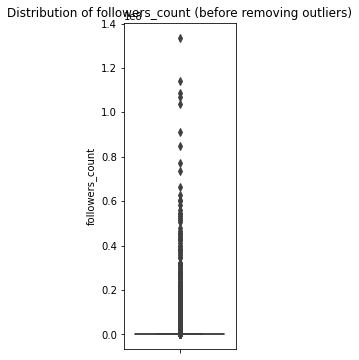

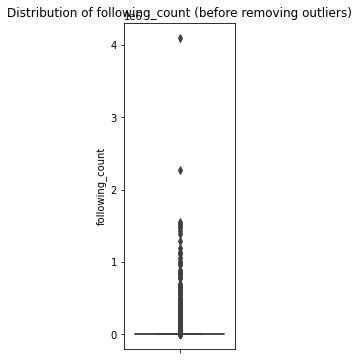

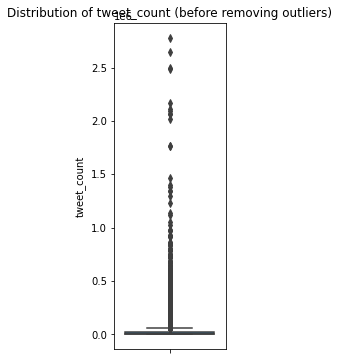

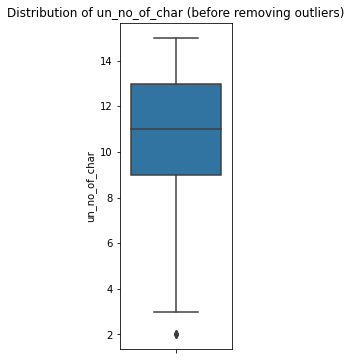

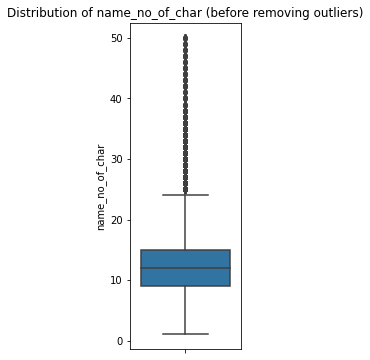

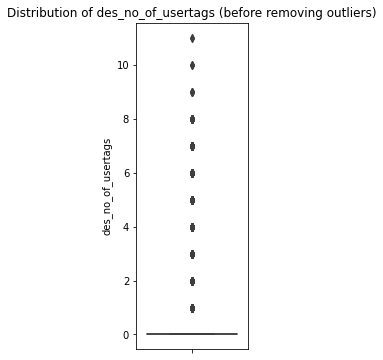

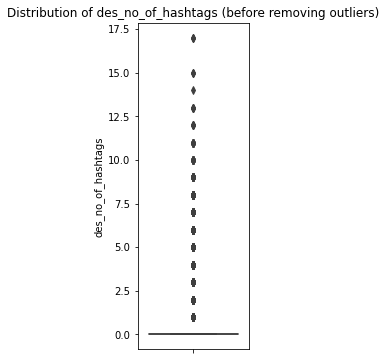

In [75]:
# Continuous variables:
# followers_count, following_count, tweet_count, un_no_of_char, name_no_of_char, des_no_of_usertags, des_no_of_hashtags

# Plotting of boxplots
continuous_var = ["followers_count", "following_count", "tweet_count", "un_no_of_char", "name_no_of_char", "des_no_of_usertags", "des_no_of_hashtags"]

for var in continuous_var:
    box_plot(var, df_tweets, "before")

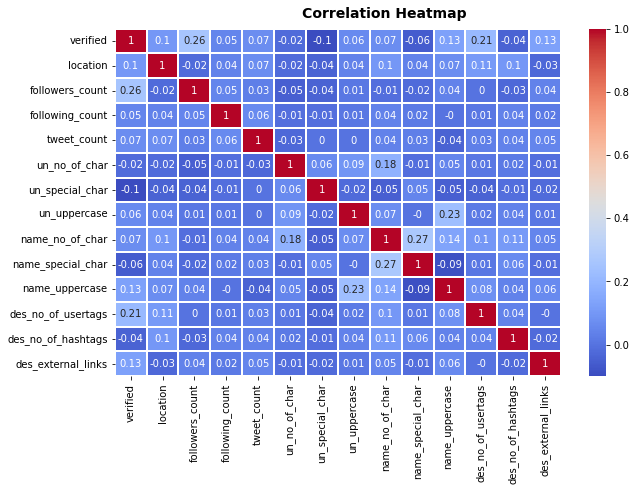

In [76]:
fig, axs8 = plt.subplots(1,1, figsize=(10,6))
hm = sns.heatmap(round(new_df_tweets.corr(),2), 
                 ax=axs8,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 linewidths=.05)
fig.subplots_adjust(top=0.93)
t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer(stop_words='english', min_df=20, max_df=40000)
cv_tfidf = TfidfVectorizer(stop_words='english', min_df=20, max_df=40000)
word_count = np.squeeze(np.asarray(cv.fit_transform(text['Comment']).sum(axis=0)))
word_count_tfidf = cv_tfidf.fit_transform(text['Comment'])
plt.figure(figsize=(8, 8))
ax = sns.kdeplot(data=pd.DataFrame({'Term Frequency': word_count}), fill=True)
ax.set_xlabel('Word Count')
ax.set_title('Distribution of Term Frequency')
plt.show()